# [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

by Simonyan and Zisserman, 2015

## Task

The task is a straight-forward supervised object recognition task. Given pixel (RGB) image representations, we want to generate labels categorizing the object in the image.

For example, in the CIFAR-10 challenge, we want to classify 32x32 pixel images into the following 10 classes

![Cifar-10 image examples](img/cifar-10.png)

## Datasets

The paper uses the [ImageNet (ILSVRC) dataset](http://www.image-net.org/challenges/LSVRC) but given the size of that dataset, we implement the same architecture on some smaller image recognition datasets: CIFAR-10 and CIFAR-100.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. CIFAR-100 is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 50000 training images and 10000 test images. State of the art performance is [~96.5% on CIFAR-10](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) and [~75.7% on CIFAR-100](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d313030).

## Architecture

The paper implements a fairly standard deep convolutional network architecture. The defining characteristics are the small receptive field sizes (convolutional filters are 3x3) and the stacking of multiple convolutional layers between each pooling step. We implement the best performing (and deepest) neural architecture from the paper: Configuration E.

![VGG architecture configurations](img/vgg-arch.png)

## Results

This architecture was one of the top-performing models submitted to ImageNet (ILSVRC) in 2014. Because we train on CIFAR-10 and CIFAR=100, we can't straight-forwardly compare performance to the results of the paper. But if implemented correctly, we'd generally expect SoA classification performance (accuracy) in the mid to high 90s.

#### Evaluate performance to an off-the-shelf pretrained VGG16

We compare performance of our implementation to that of a pretrained model. Because we couldn't find a pretrained CIFAR-10 model in keras/tensorflow, we load up an MxNet model: https://gluon-cv.mxnet.io/build/examples_classification/demo_cifar10.html. This is a ResNet rather than VGG architecture, but should give us a ballpark confirmation of the kind of accuracy we should aim for on this dataset with a standard deep conv net.

In [ ]:
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model

pretrained = get_model('cifar_resnet110_v1', classes=10, pretrained=True)

def evaluate_with_pretrained(pretrained_model, img, true_label):
    nd_img = nd.array(img)
    transform_fn = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
    nd_img = transform_fn(nd_img)
    pred = pretrained(nd_img.expand_dims(0))
    label = nd.argmax(pred, axis=1).astype('int').asnumpy()[0]
    return int(label == true_label)

acc = []
for x, y in zip(x_test[:1000], y_test[:1000]):
    acc.append(evaluate_with_pretrained(pretrained, x, y[0]))

In [ ]:
print("Accuracy of pretrained CIFAR-10 ResNet: %.3f" % np.mean(acc))

As expected, a pretrained model performs in the mid-90s. We should be able to obtain comparable results with a VGG architecture.

#### Our model's performance on test data

For our implementation of the VGG architecture, trained on CIFAR-10, we observe classification accuracy of **73.5%** on the unseen test data. Womp womp.

#### Visualize performance on a subset of test data

In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

import training
import vgg.model
import evaluation
import run

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
x_shape = (1000, 32, 32, 3)
model_spec = run.get_model_spec("vgg", "cifar10")
model = model_spec.construct_model()
model = training.load_latest_checkpoint(model, "..", x_shape, checkpoint_dirname="checkpoints-cifar-10-73")

Loading model from latest checkpoint: ../checkpoints-cifar-10-73/ckpt-3906
INFO:tensorflow:Restoring parameters from ../checkpoints-cifar-10-73/ckpt-3906


In [7]:
from tensorflow.keras.datasets import cifar10, cifar100
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
sample_n = 100
forward = model.predict(x_test[:sample_n])
predictions = np.argmax(forward, axis=1)

Accuracy: 0.7500


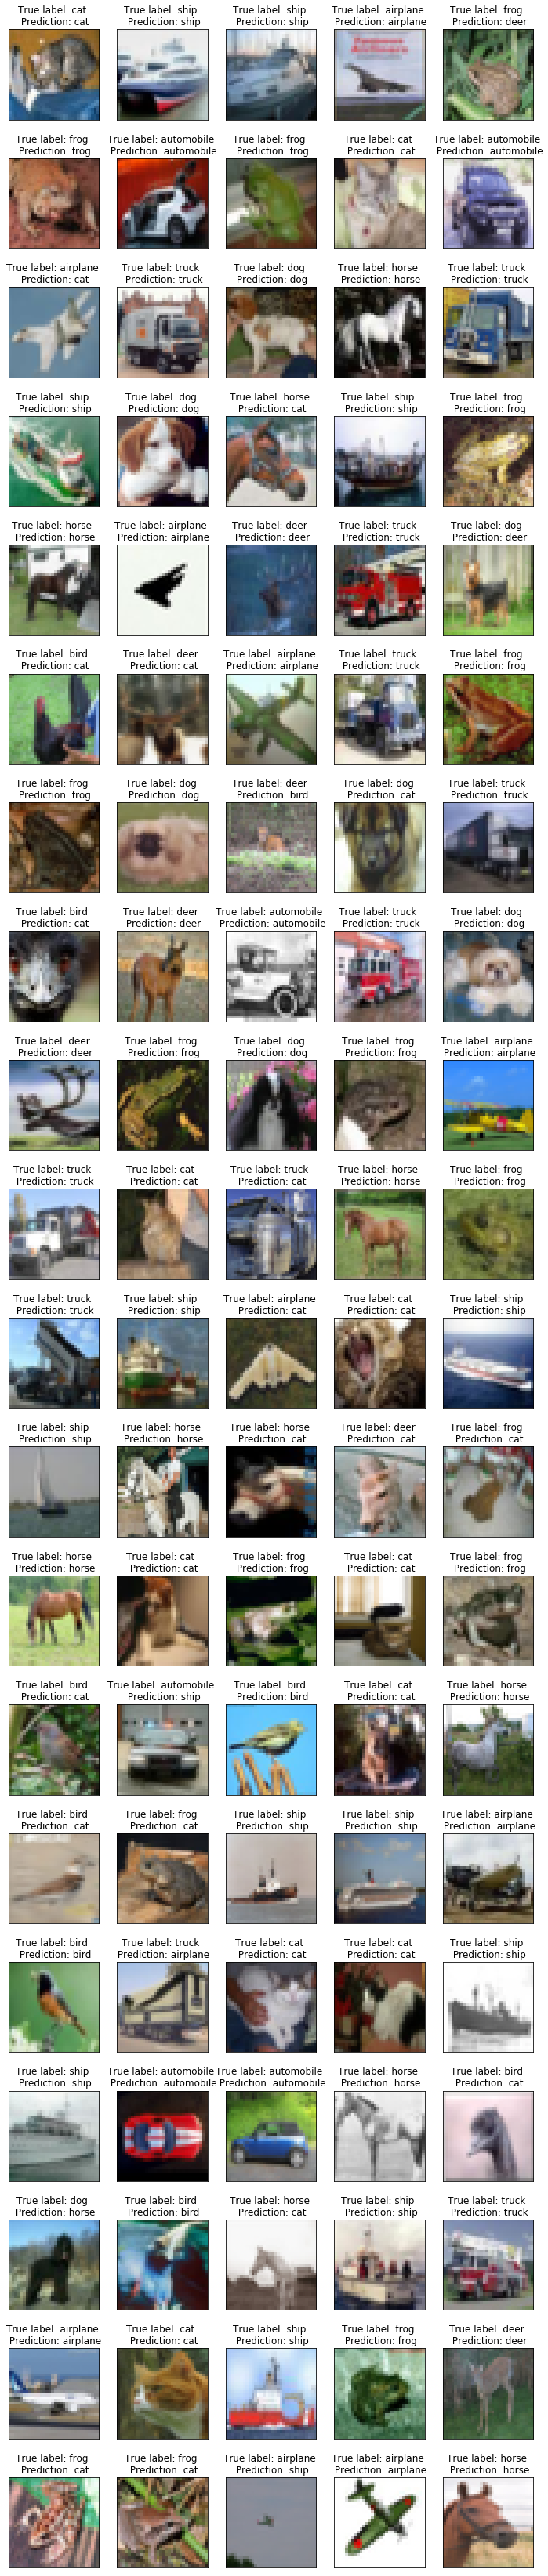

In [8]:
fig, axs = plt.subplots(int(sample_n / 5), 5, figsize=(12, int(12 * sample_n / 20)))
acc = []
for i, img, pred, label in zip(range(sample_n), x_test[:sample_n], predictions, y_test.squeeze(axis=1)[:sample_n]):
    title = "True label: %s \n Prediction: %s" % (class_names[label], class_names[pred])
    acc.append(int(label == pred))
    ax = axs[i // 5][i % 5]
    ax.set_title(title)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.imshow(img)
print("Accuracy: %.4f" % np.mean(acc))